# Notebook 1. Manually Adjust Pose and Expression of An Avatar

In [1]:
import os
os.chdir("/home/yhding/Repo/Imp_NeuAvatar/")
from nha.util.render import create_intrinsics_matrix
import torch
from nha.models.nha_optimizer import NHAOptimizer
from nha.util.general import dict_2_device
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ckpt = "ckpts_and_data/nha/person_0004.ckpt" # pretrained model
# ckpt = "default_dir/lightning_logs/version_2/checkpoints/last.ckpt" # pretrained model

tracking_results="ckpts_and_data/tracking/person_0004.npz" # head tracking file
# tracking_results="OUTPUT_PATH/tracking_0/tracked_flame_params.npz" # head tracking file

In [5]:
avatar = NHAOptimizer.load_from_checkpoint(ckpt).eval().cuda()
tr = np.load(tracking_results)

/home/yhding/miniconda3/envs/avatar/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: ModelCheckpoint(save_last=True, monitor=None) is a redundant configuration. You can save the last checkpoint with ModelCheckpoint(save_top_k=None, monitor=None).
  warnings.warn(*args, **kwargs)
/home/yhding/miniconda3/envs/avatar/lib/python3.9/site-packages/pytorch3d/structures/meshes.py:1107: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


In [6]:
# Synthesizing novel poses and expressions
@torch.no_grad()
def synthesize_novel_poses_and_expressions(expr = torch.zeros(100, dtype=torch.float),
                                           pose = torch.zeros(15, dtype=torch.float), image_size = (512, 512)):
    
    img_h, img_w = image_size
    track_h, track_w = tr['image_size']
    fx_scale = max(track_h, track_w) * img_w / track_w
    fy_scale = max(track_h, track_w) * img_h / track_h
    cx_scale = img_w
    cy_scale = img_h
    cam_intrinsics = create_intrinsics_matrix(
        fx=tr["K"][0] * fx_scale,
        fy=tr["K"][0] * fy_scale,
        px=tr["K"][1] * cx_scale,
        py=tr["K"][2] * cy_scale,
    ) 

    # creating batch with inputs to avatar
    rest_joint_rots = avatar._flame.get_neutral_joint_rotations()
    default_pose = torch.cat((rest_joint_rots["global"], 
                              rest_joint_rots["neck"], 
                              rest_joint_rots["jaw"], 
                              rest_joint_rots["eyes"],
                              rest_joint_rots["eyes"]
                             ), dim=0).cpu()
    
    batch = dict(
                flame_shape = torch.from_numpy(tr["shape"][None]).float(),
                flame_expr = expr[None],
                flame_pose = (pose+default_pose)[None],
                flame_trans = torch.from_numpy(tr["translation"][[0]]).float(),
                cam_intrinsic=cam_intrinsics[None],
                cam_extrinsic=torch.from_numpy(tr["RT"]).float()[None],
                rgb=torch.zeros(1,3,img_h,img_w))    
    
    batch = dict_2_device(batch, avatar.device)
    
    
    # make prediction
    rgba = avatar.forward(batch, symmetric_rgb_range=False)
    shaded_mesh = avatar.predict_shaded_mesh(batch)

    return rgba, shaded_mesh
    
    

In [7]:
"""
Adjust pose:
    rot0,1,2 : global head rotation
    neck0,1,2 : neck rotation
"""

from ipywidgets import interactive

def f_pos(jaw, rot0, rot1, rot2, neck0, neck1, neck2):
    expr = torch.zeros(100, dtype=torch.float)
    pose = torch.zeros(15, dtype=torch.float)

    # expression parameters
    e0 = 0
    e1 = 0
    e2 = 0
    e3 = 0
    e4 = 0

    expr[0] = e0; expr[1] = e1; expr[2] = e2; expr[3] = e3; expr[4] = e4
    pose[0] = rot0; pose[1] = rot1;  pose[2] = rot2; pose[3] = neck0;  pose[4] = neck1; pose[5] = neck2; pose[6] = jaw
    %time

    rgba, shaded_mesh = synthesize_novel_poses_and_expressions(expr=expr, pose=pose, image_size=(512,512))

    fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    axes[0].imshow(rgba[0,:3].cpu().permute(1,2,0))
    axes[1].imshow(shaded_mesh[0, :3].cpu().permute(1,2,0))

    [a.axis("off") for a in axes]
    plt.show()
    
interactive_plot_pos = interactive(f_pos, jaw = (.0, 1.0), rot0=(-.5, .5), rot1=(np.pi-1, np.pi+1),rot2=(-.5, .5), neck0=(-.5, .5), neck1=(-45,45), neck2=(-0.5,.5))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
interactive_plot_pos

interactive(children=(FloatSlider(value=0.5, description='jaw', max=1.0), FloatSlider(value=0.0, description='…

In [20]:
"""
Adjust expressions
"""

def f_exp(e0, e1, e2, e3, e4):
    expr = torch.zeros(100, dtype=torch.float)
    pose = torch.zeros(15, dtype=torch.float)

    # global rotation
    rot0 = 0
    rot1 = np.pi
    rot2 = 0

    # neck rotation
    neck0 = 0 # up and down (-.5, .5)
    neck1 = 0 # twist (-45,45)
    neck2 = 0 # tilte head (-.5, .5)

    # jaw movement 
    jaw = 0 # (0,1)

    expr[0] = e0; expr[1] = e1; expr[2] = e2; expr[3] = e3; expr[4] = e4
    pose[0] = rot0; pose[1] = rot1;  pose[2] = rot2; pose[3] = neck0;  pose[4] = neck1; pose[5] = neck2; pose[6] = jaw
    %time

    rgba, shaded_mesh = synthesize_novel_poses_and_expressions(expr=expr, pose=pose, image_size=(512,512))

    fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    axes[0].imshow(rgba[0,:3].cpu().permute(1,2,0))
    axes[1].imshow(shaded_mesh[0, :3].cpu().permute(1,2,0))

    [a.axis("off") for a in axes]
    plt.show()
    
interactive_plot_exp = interactive(f_exp, e0=(-5.0, 5.0,0.5), e1=(-5.0,5.0), e2=(-5.0,5.0), e3=(-5.0,5.0, 0.5), e4=(-5.0,5.0,1.0))
interactive_plot_exp

interactive(children=(FloatSlider(value=0.0, description='e0', max=5.0, min=-5.0, step=0.5), FloatSlider(value…

In [21]:
import cv2

driver_frame = 'ckpts_and_data/data/person_0004/frame_1200/image_0000.png'
rgb_driver = cv2.imread(driver_frame)

target_frame = '/tmp/scene_reenactment_drive/1200.png'
rgb_target = cv2.imread(target_frame)
# tracking_results_0004 = 'ckpts_and_data/tracking/person_0004.npz'
# tr_0004 = np.load(tracking_results_0004)


In [11]:
"""
Display the drvier's exp/pose on the target's head frame-by-frame
"""


@torch.no_grad()
def reenact_avatar(target_model: NHAOptimizer, driving_model: NHAOptimizer, target_tracking_results: dict,
                   driving_tracking_results: dict, outpath: Path,
                   neutral_driving_frame=0, neutral_target_frame=0,
                   batch_size=3, plot=False):
    base_drive_sample = dict_2_device(tracking_results_2_data_batch(driving_tracking_results, [neutral_driving_frame]),
                                      driving_model.device)
    base_target_sample = dict_2_device(tracking_results_2_data_batch(target_tracking_results, [neutral_target_frame]),
                                       target_model.device)

    base_drive_params = driving_model._create_flame_param_batch(base_drive_sample)
    base_target_params = target_model._create_flame_param_batch(base_target_sample)

    tmp_dir_pred = Path("/tmp/scene_reenactment_pred")
    tmp_dir_drive = Path("/tmp/scene_reenactment_drive")
    os.makedirs(tmp_dir_drive, exist_ok=True)
    os.makedirs(tmp_dir_pred, exist_ok=True)
    os.makedirs(outpath.parent, exist_ok=True)
    os.system(f"rm -r {tmp_dir_drive}/*")
    os.system(f"rm -r {tmp_dir_pred}/*")
    frameid2imgname = lambda x: f"{x:04d}.png"

    for idcs in tqdm(torch.split(torch.from_numpy(driving_tracking_results["frame"]), batch_size)):
        batch = dict_2_device(tracking_results_2_data_batch(driving_tracking_results, idcs.tolist()), target_model.device)

        rgb_driving = driving_model.forward(batch, symmetric_rgb_range=False)[:, :3].clamp(0,1)

        # change camera parameters
        batch["cam_intrinsic"] = base_target_sample["cam_intrinsic"].expand_as(batch["cam_intrinsic"])
        batch["cam_extrinsic"] = base_target_sample["cam_extrinsic"].expand_as(batch["cam_extrinsic"])

        rgb_target = target_model.predict_reenaction(batch, driving_model=driving_model,
                                                     base_target_params=base_target_params,
                                                     base_driving_params=base_drive_params)
        

rgb_avatar = avatar.predict_reenaction(batch, driving_model=avatar, base_target_params=base_target_params,
                                                     base_driving_params=base_drive_params)


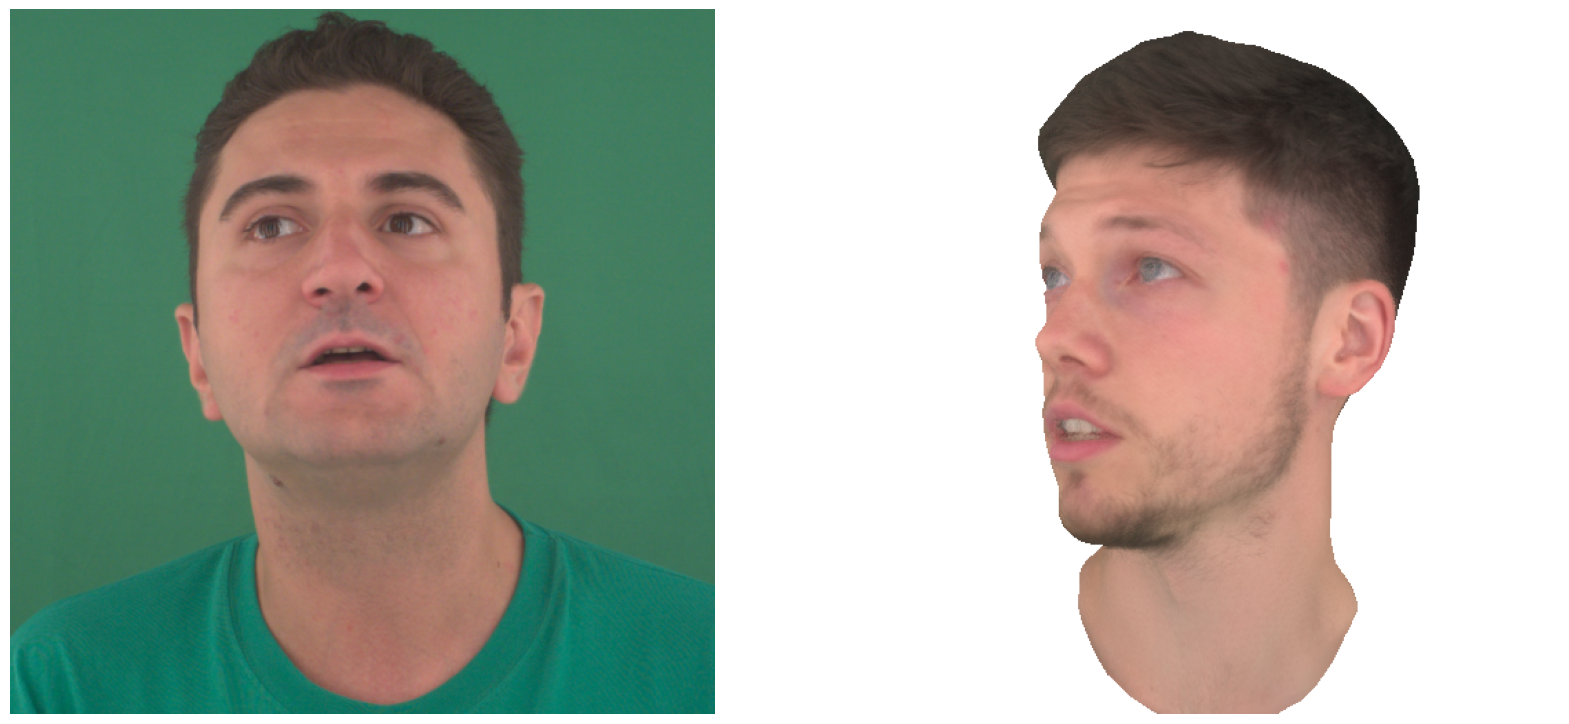

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes[0].imshow(cv2.cvtColor(rgb_driver, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(rgb_target, cv2.COLOR_BGR2RGB))

# axes[1].imshow(rgba[0,:3].cpu().permute(1,2,0))
[a.axis("off") for a in axes]
plt.show()